Talking Numbers: A Musical Taste Exploration and a Song Classifier
=====

In [197]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import time 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import manifold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Data Extraction

In [ ]:
# DEFINE LOGIN CREDENTIALS
#userID         = 
#client_id      = 
#client_secret  = 

#Code used to built the Dataset

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# LOAD DATASETS IDS FROM CSV FILE
IDs_df = pd.read_csv("Data/DatasetsIDs.csv",";")

In [ ]:
# Load Playlists and Save into Data Folder

def getTrackIDs(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    IDs = []
    for i in range(len(tracks)):
        IDs.append(tracks[i]["track"]['id']) 
    return IDs


# Function for retrieving track ids
def getTrackIDs_OLD(user, playlist_id):
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return ids

# Function that extracts track features
def getTrackFeatures(id):
    try:
      meta = sp.track(id)
      features = sp.audio_features(id)

      # meta
      name = meta['name']
      album = meta['album']['name']
      artist = meta['album']['artists'][0]['name']
      release_date = meta['album']['release_date']
      length = meta['duration_ms']
      popularity = meta['popularity']

      # features
      acousticness = features[0]['acousticness']
      danceability = features[0]['danceability']
      energy = features[0]['energy']
      instrumentalness = features[0]['instrumentalness']
      liveness = features[0]['liveness']
      loudness = features[0]['loudness']
      speechiness = features[0]['speechiness']
      tempo = features[0]['tempo']
      time_signature = features[0]['time_signature']

      track = [name, album, artist, release_date, length, popularity, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
      return track
    except:
      return []

# Loop through Datasets
for index, row in IDs_df.iterrows():
    if row['ID'] == 0:
        ID   = row['ID']
        Name = row['Dataset']
        ids = getTrackIDs(userID, ID)

        # loop over track ids 
        tracks = []
        for i in range(len(ids)):
          track = getTrackFeatures(ids[i])
          if len(track) > 0:
              tracks.append(track)

        # create dataset
        df = pd.DataFrame(tracks, columns = ['name', 'album', 'artist', 'release_date', 'length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])

        df.to_csv("Data/Datasets/Dataset" + str(Name) + ".csv", sep = ',')

 

# Data Transform

In [283]:
# Data Visualization

L  = pd.DataFrame()
DL = pd.read_csv("Data/Datasets/Dataset0.csv",",")

for play in range(1,20):
    playDf = pd.read_csv("Data/Datasets/Dataset" + str(play) + ".csv") 
    L=pd.concat([L,playDf])
    
    
# Select Relevant Features __________________________________________________________________________________________________________________________  

L  =  L[['release_date','popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]
L['Classification'] = 1

DL = DL[['release_date','popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]
DL['Classification'] = 0


# Remove observations with NaN in a given feature ___________________________________________________________________________________________________
L.dropna()
DL.dropna()
    
# Change date info  _________________________________________________________________________________________________________________________________

for index, row in L.iterrows():
        Date    = row['release_date']
        newDate = Date[0:4]
        L.at[index,'release_date'] = newDate
        
for index, row in DL.iterrows():
        Date    = row['release_date']
        newDate = Date[0:4]
        DL.at[index,'release_date'] = newDate        

L['release_date'] = L['release_date'].astype('float64')
DL['release_date'] = DL['release_date'].astype('float64')

L['popularity'] = L['popularity'].astype('float64')
DL['popularity'] = DL['popularity'].astype('float64')


# UNIFY 
ALL = pd.concat([L,DL])
#all is the variable with all the data labeled 

ALL.to_csv("Data/Datasets/Dataset_ALL.csv", sep = ',')

ALL

release_date  popularity  acousticness  danceability  energy  \
0           2018.0        35.0        0.9760         0.240  0.1570   
1           1964.0         0.0        0.8770         0.291  0.0939   
2           2018.0        63.0        0.9630         0.212  0.3010   
3           1984.0        56.0        0.9620         0.424  0.2140   
4           1980.0        59.0        0.9590         0.369  0.2100   
...            ...         ...           ...           ...     ...   
3008        2020.0        51.0        0.0966         0.839  0.4970   
3009        2020.0        56.0        0.0213         0.908  0.6960   
3010        2021.0        87.0        0.0136         0.781  0.5940   
3011        2021.0        72.0        0.2480         0.721  0.5650   
3012        2021.0        90.0        0.0012         0.868  0.7950   

      instrumentalness  liveness  loudness  speechiness    tempo  \
0             0.924000    0.1080   -17.034       0.0382   68.828   
1             0.779000    0.0799   -21.057       0.0342  102.084   
2             0.003300    0.1300   -12.505       0.0384   84.025   
3             0.000029    0.6810   -17.688       0.0763  113.211   
4             0.000045    0.0905   -13.552       0.0437  131.714   
...                ...       ...       ...          ...      ...   
3008          0.000000    0.0940    -6.088       0.3110   76.029   
3009          0.000041    0.0747    -5.180       0.2640  102.032   
3010          0.000000    0.1620    -6.959       0.0485  129.895   
3011          0.000000    0.2840    -9.157       0.2800   93.800   
3012          0.019300    0.0461    -6.044       0.2690  166.000   

      Classification  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
...              ...  
3008               0  
3009               0  
3010               0  
3011               0  
3012               0  

[8480 rows x 11 columns]

In [284]:
# LOAD EXTRACTION RESULT (WITHOUT RELEASE DATE)

import pandas as pd

# Data Visualization

L  = pd.DataFrame()
DL = pd.read_csv("Data/Datasets/Dataset0.csv",",")

for play in range(1,20):
    playDf = pd.read_csv("Data/Datasets/Dataset" + str(play) + ".csv") 
    L=pd.concat([L,playDf])
    
    
# Select Relevant Features __________________________________________________________________________________________________________________________  

L  =  L[['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]
L['Classification'] = 1

DL = DL[['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]
DL['Classification'] = 0


# Remove observations with NaN in a given feature ___________________________________________________________________________________________________
L.dropna()
DL.dropna()

L['popularity'] = L['popularity'].astype('float64')
DL['popularity'] = DL['popularity'].astype('float64')


# UNIFY 
ALL_noDate = pd.concat([L,DL])

ALL_noDate.to_csv("Data/Datasets/Dataset_ALL_noDate.csv", sep = ',')

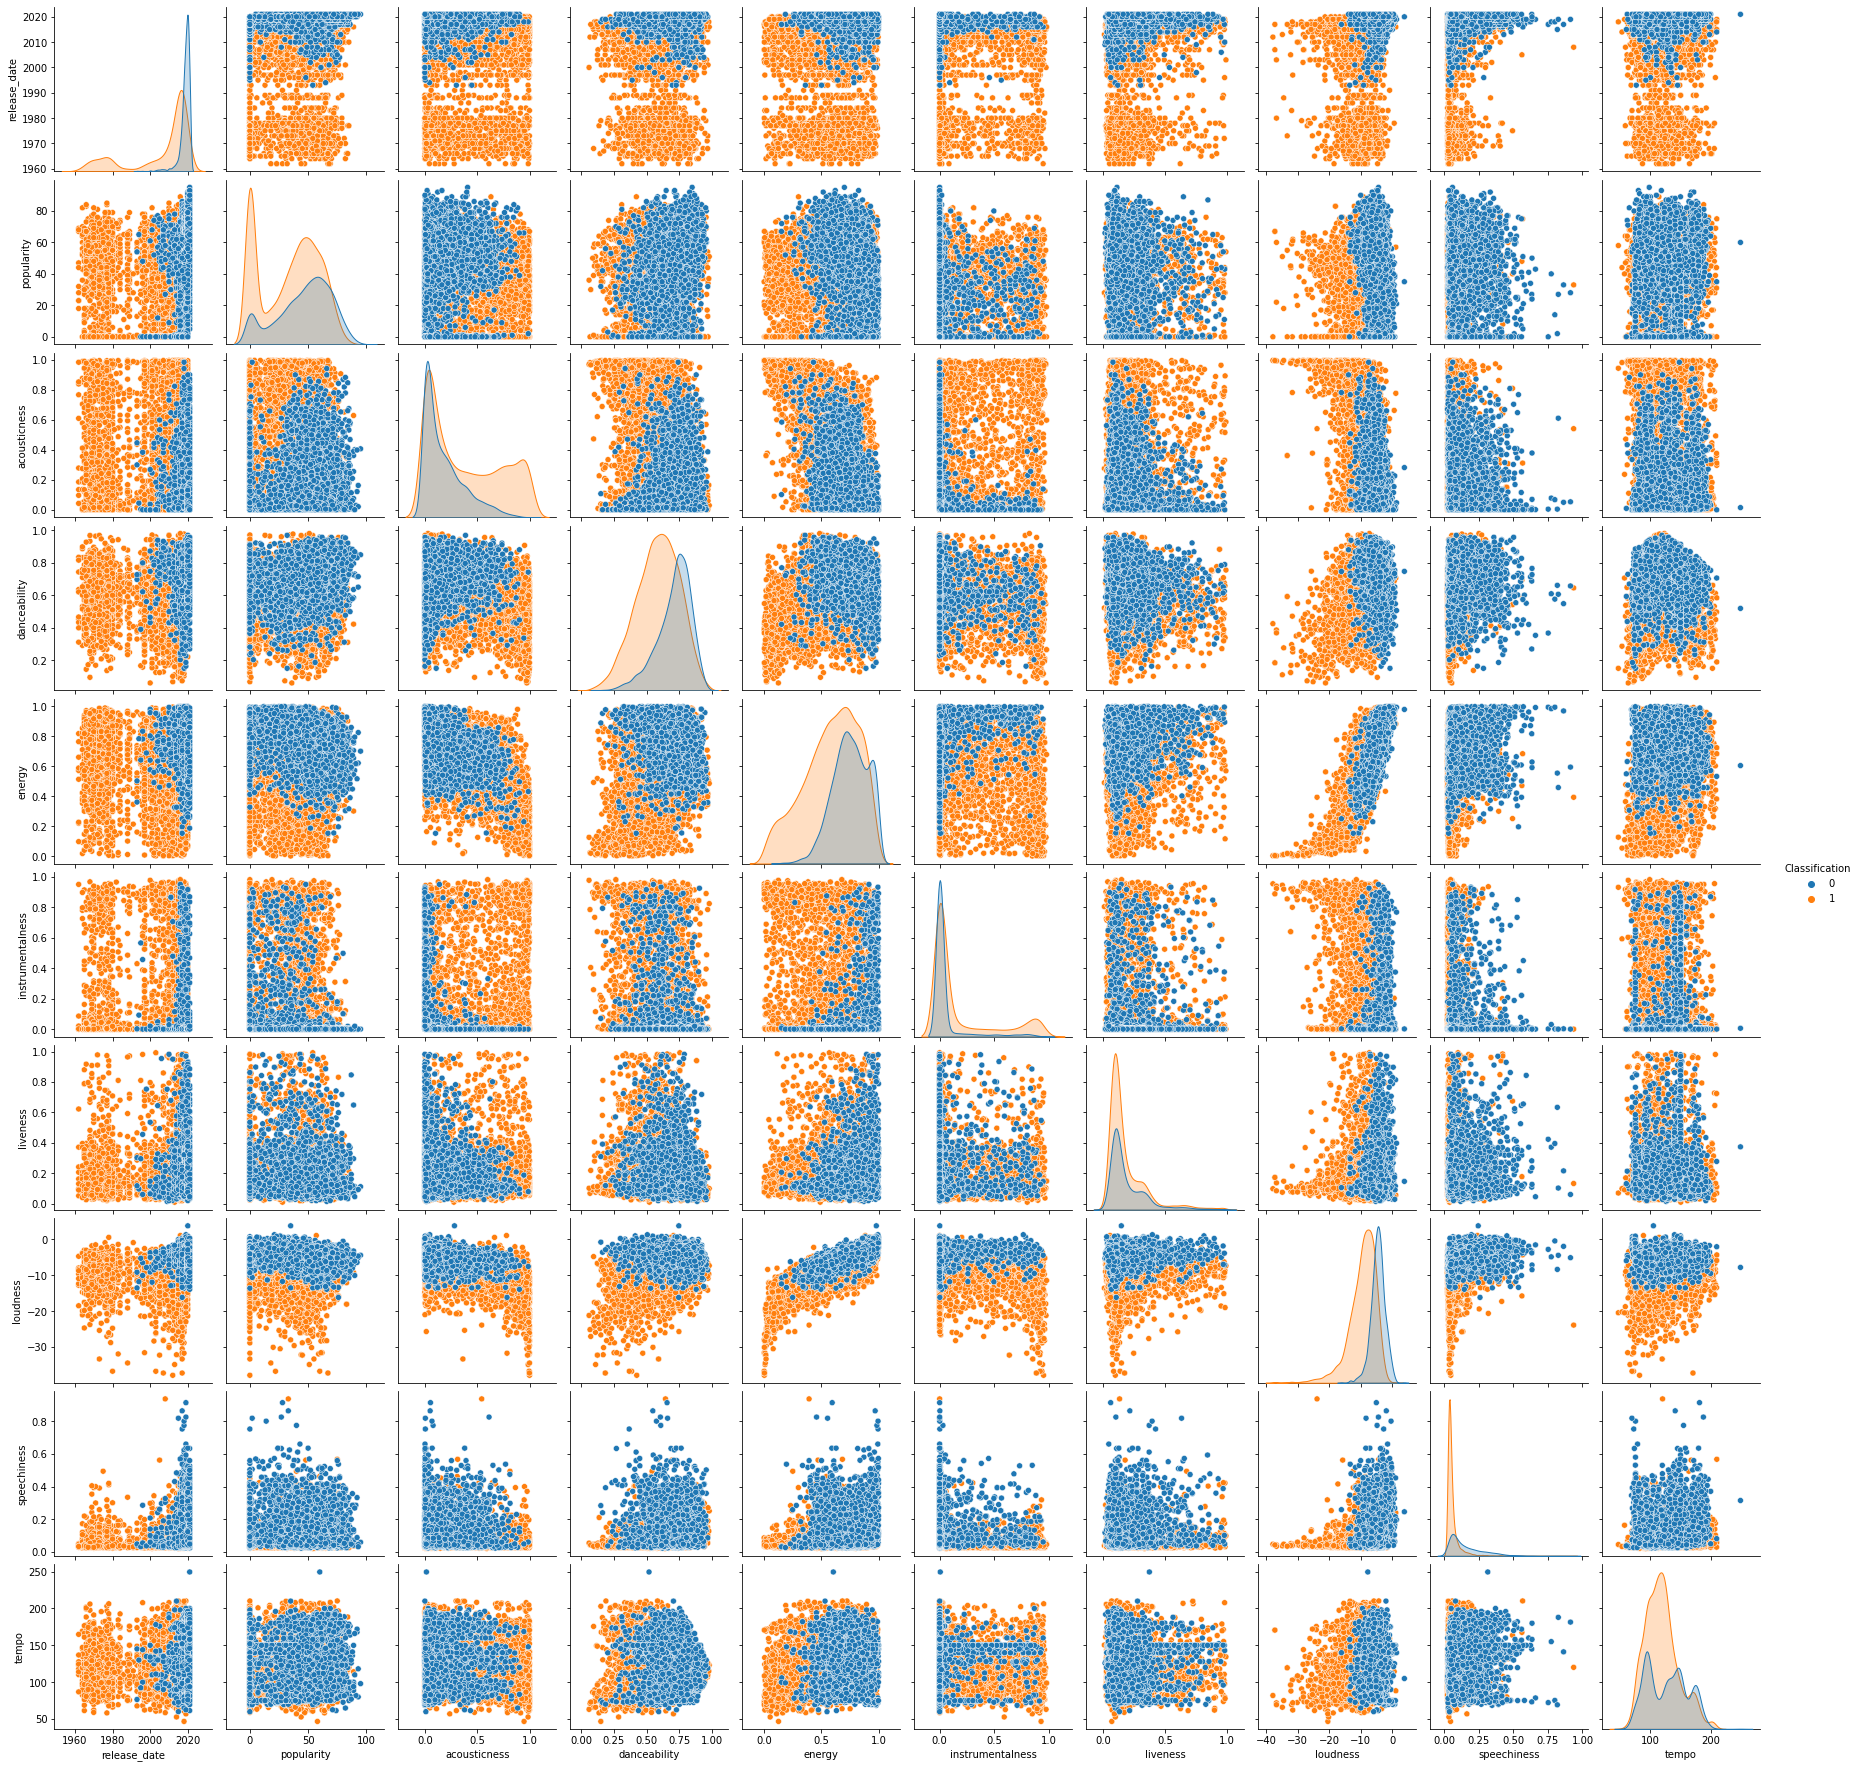

In [285]:
# Create the default pairplot
sns.pairplot(ALL,hue="Classification")   

In [410]:
# Visualize only diagonal


<Figure size 432x288 with 0 Axes>

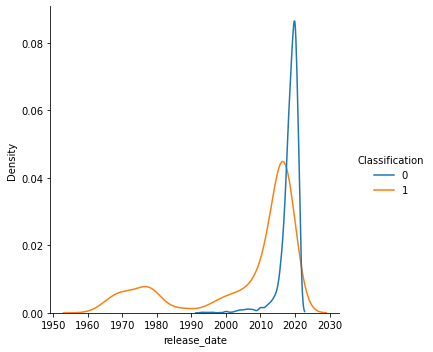

In [408]:
plt.figure()
sns.displot(ALL,x="release_date",hue='Classification', kind="kde")
plt.savefig('2')

<Figure size 432x288 with 0 Axes>

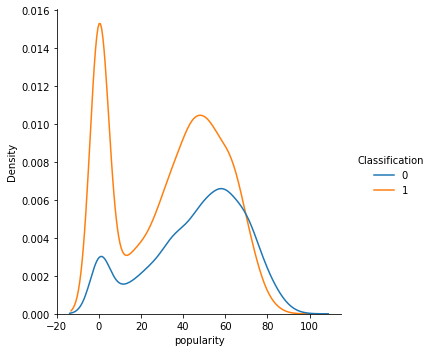

In [407]:
plt.figure()
sns.displot(ALL,x="popularity",hue='Classification' ,kind="kde")
plt.savefig('3')

<Figure size 432x288 with 0 Axes>

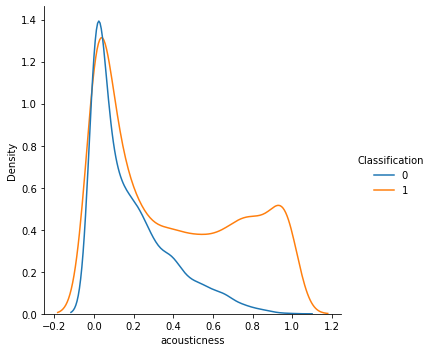

In [394]:
plt.figure()
sns.displot(ALL,x="acousticness",hue='Classification' ,kind="kde")
plt.savefig('4')

<Figure size 432x288 with 0 Axes>

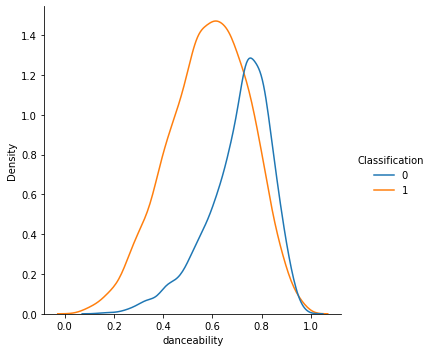

In [395]:
plt.figure()
sns.displot(ALL,x="danceability",hue='Classification' ,kind="kde")
plt.savefig('5')

<Figure size 432x288 with 0 Axes>

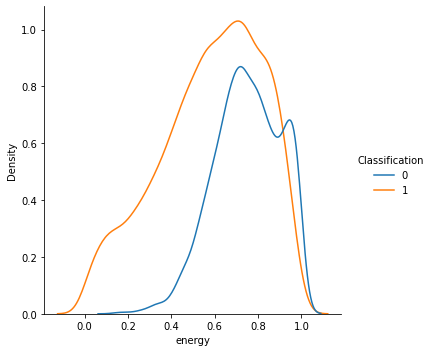

In [396]:
plt.figure()
sns.displot(ALL,x="energy",hue='Classification' ,kind="kde")
plt.savefig('6')

<Figure size 432x288 with 0 Axes>

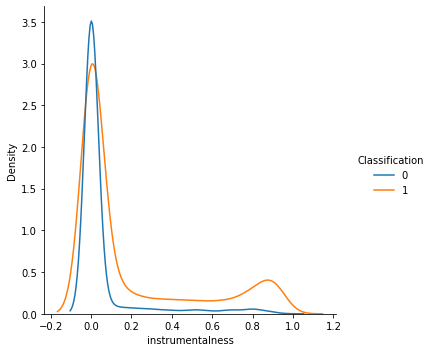

In [397]:
plt.figure()
sns.displot(ALL,x="instrumentalness",hue='Classification' ,kind="kde")
plt.savefig('7')

<Figure size 432x288 with 0 Axes>

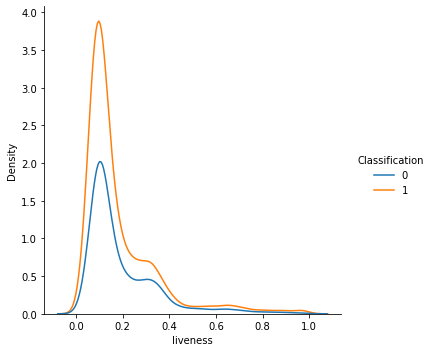

In [398]:
plt.figure()
sns.displot(ALL,x="liveness",hue='Classification' ,kind="kde")
plt.savefig('8')

<Figure size 432x288 with 0 Axes>

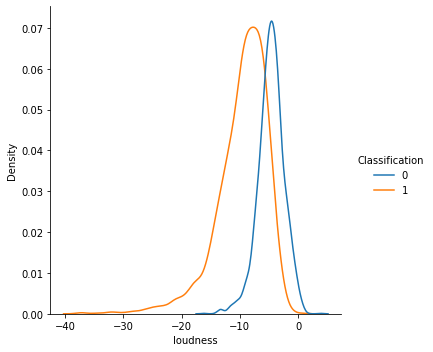

In [399]:
plt.figure()
sns.displot(ALL,x="loudness",hue='Classification' ,kind="kde")
plt.savefig('9')

<Figure size 432x288 with 0 Axes>

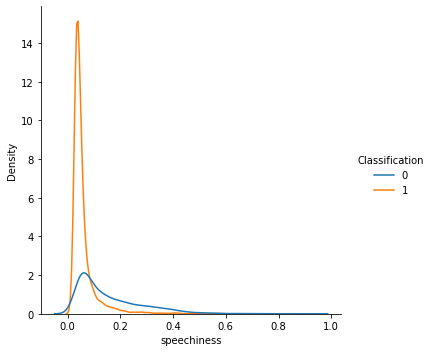

In [400]:
plt.figure()
sns.displot(ALL,x="speechiness",hue='Classification' ,kind="kde")
plt.savefig('10')

<Figure size 432x288 with 0 Axes>

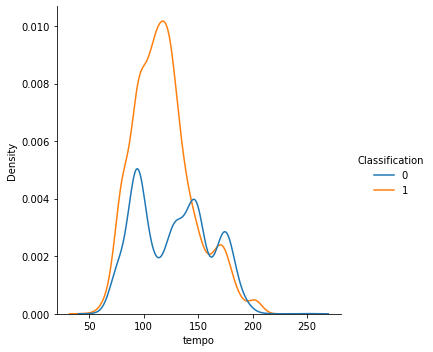

In [401]:
plt.figure()
sns.displot(ALL,x="tempo",hue='Classification' ,kind="kde")
plt.savefig('11')

# PCA 

In [402]:
Dataset = ALL.copy() 
DatasetnoData= ALL_noDate.copy()
DatasetnoData.drop('Classification', inplace=True, axis=1)
Dataset.drop('Classification', inplace=True, axis=1)
Dataset

release_date  popularity  acousticness  danceability  energy  \
0           2018.0        35.0        0.9760         0.240  0.1570   
1           1964.0         0.0        0.8770         0.291  0.0939   
2           2018.0        63.0        0.9630         0.212  0.3010   
3           1984.0        56.0        0.9620         0.424  0.2140   
4           1980.0        59.0        0.9590         0.369  0.2100   
...            ...         ...           ...           ...     ...   
3008        2020.0        51.0        0.0966         0.839  0.4970   
3009        2020.0        56.0        0.0213         0.908  0.6960   
3010        2021.0        87.0        0.0136         0.781  0.5940   
3011        2021.0        72.0        0.2480         0.721  0.5650   
3012        2021.0        90.0        0.0012         0.868  0.7950   

      instrumentalness  liveness  loudness  speechiness    tempo  
0             0.924000    0.1080   -17.034       0.0382   68.828  
1             0.779000    0.0799   -21.057       0.0342  102.084  
2             0.003300    0.1300   -12.505       0.0384   84.025  
3             0.000029    0.6810   -17.688       0.0763  113.211  
4             0.000045    0.0905   -13.552       0.0437  131.714  
...                ...       ...       ...          ...      ...  
3008          0.000000    0.0940    -6.088       0.3110   76.029  
3009          0.000041    0.0747    -5.180       0.2640  102.032  
3010          0.000000    0.1620    -6.959       0.0485  129.895  
3011          0.000000    0.2840    -9.157       0.2800   93.800  
3012          0.019300    0.0461    -6.044       0.2690  166.000  

[8480 rows x 10 columns]

In [298]:
DS = StandardScaler().fit_transform(Dataset)
DSnodata = StandardScaler().fit_transform(DatasetnoData)

pca = decomposition.PCA(n_components=9).fit(DS)
pcaNoData =  decomposition.PCA(n_components=8).fit(DSnodata)
print('Explained variance = {} {} {} {} {} {} {} {} '.format(*pca.explained_variance_ratio_))

Explained variance = 0.2859560686615302 0.12901089021318976 0.10803961942727199 0.09756208468442626 0.0960860290813166 0.0831315640002413 0.07607059441785195 0.06352009328512503 


In [299]:
100*pca.explained_variance_ratio_.cumsum()

array([28.59560687, 41.49669589, 52.30065783, 62.0568663 , 71.66546921,
       79.97862561, 87.58568505, 93.93769438, 98.39497177])

In [365]:
Xproj = pca.transform(DS) 
XprojNoData = pcaNoDate.transform(DSnodate)  
Xreduced = Xproj[:,0:8]
XreducedNoData = XprojNoData[:,0:8]

print('Dimensionalidad datos en espacio PCA reducido = {}'.format(Xreduced.shape))

Dimensionalidad datos en espacio PCA reducido = (8480, 8)


In [366]:
dfpca = pd.DataFrame(Xproj[:,0:8], columns=['PCA1', 'PCA2','PCA3', 'PCA4', 'PCA5','PCA6',  'PCA7','PCA8'])
dfpcaNoData = pd.DataFrame(XprojNoData[:,0:8], columns=['PCA1', 'PCA2','PCA3', 'PCA4', 'PCA5','PCA6',  'PCA7','PCA8'])

labels0 = np.zeros(3013)
labels1 = np.ones(5467)
labels= np.concatenate([labels0, labels1])

dfpca['label']=labels
dfpcaNoData['label']=labels
dfpca

PCA1      PCA2      PCA3      PCA4      PCA5      PCA6      PCA7  \
0     4.751188  0.378111  0.648676  0.722785 -1.231379 -1.806269  0.336977   
1     5.805559  1.265831 -0.561544 -0.989401 -0.074509  1.058576  1.374711   
2     2.860570 -0.719168  0.571637  0.664989  1.061685 -1.155337 -1.504685   
3     3.345431  0.710867  0.398989  1.865909  3.450002  0.263920  0.709648   
4     3.250336 -0.629629  0.244628 -1.093646  2.064055  0.567985 -0.185211   
...        ...       ...       ...       ...       ...       ...       ...   
8475 -1.221537 -1.928670  0.650603  1.299830 -0.700553  0.710238  1.040794   
8476 -1.992480 -1.762804  0.491738  0.521947 -0.674103  0.486287  0.959997   
8477 -1.114841 -1.583044  0.045026 -0.336209  0.677799 -1.288688  0.077099   
8478 -0.821839 -1.308691  1.086156  1.520063  0.603479 -0.200467  1.044910   
8479 -2.568865 -1.688208  1.688986 -1.108486  0.363143 -0.317780  1.166532   

          PCA8  label  
0     1.452434    0.0  
1     0.984465    0.0  
2     1.729936    0.0  
3    -0.418985    0.0  
4     0.701497    0.0  
...        ...    ...  
8475  1.255300    1.0  
8476  0.523002    1.0  
8477 -0.629439    1.0  
8478  0.906918    1.0  
8479 -0.011819    1.0  

[8480 rows x 9 columns]

<Figure size 1008x1008 with 0 Axes>

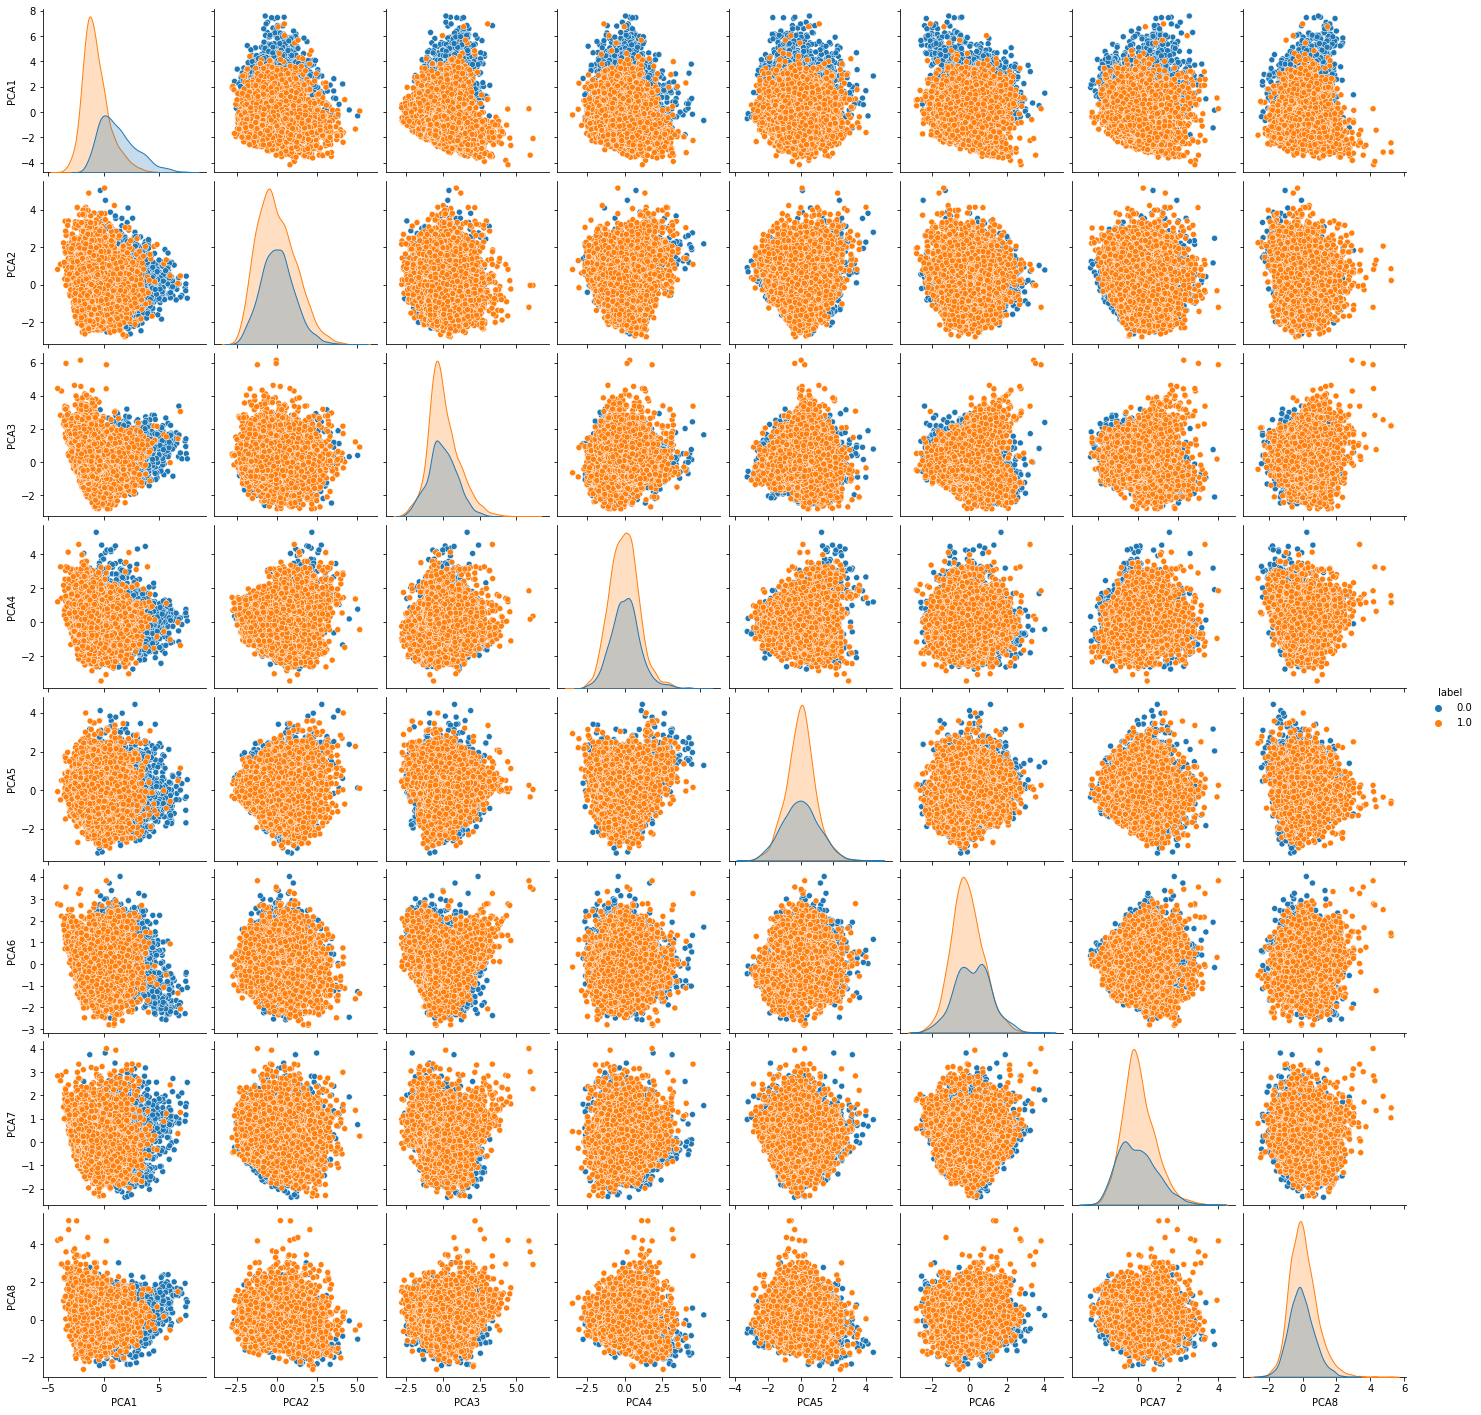

In [301]:
fig = plt.figure(figsize=(14, 14))
sns.pairplot(dfpca, hue='label')
plt.show()

# Data exploration

In [302]:
ALL_raw = ALL.copy()
Classification = ALL_raw['Classification']

ALL_raw = ALL_raw.drop(['Classification'],axis=1)

Like=  ALL.loc[ALL['Classification'] == 1]
Like = Like.drop(['Classification'],axis=1)

UnLike = ALL.loc[ALL['Classification'] == 0]
UnLike = UnLike.drop(['Classification'],axis=1)


In [303]:
#BIC ESTIMATION IN COMPLETE DATASET
from sklearn import mixture
import numpy as np

n_clusters = 6
NMAX = 20

bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(ALL_raw)
    bic.append(gmm.bic(ALL_raw))
    #print(bic)
idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

...and the winner is GMM model G = 19


In [304]:
#BIC ESTIMATION FOR LIKE DATASET
from sklearn import mixture
import numpy as np

n_clusters = 6
NMAX = 20

bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(Like)
    bic.append(gmm.bic(Like))
    #print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

...and the winner is GMM model G = 15


In [305]:
#BIC ESTIMATION FOR UNLIKE DATASET
from sklearn import mixture
import numpy as np

n_clusters = 6
NMAX = 20

bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(UnLike)
    bic.append(gmm.bic(UnLike))
    #print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))


...and the winner is GMM model G = 17


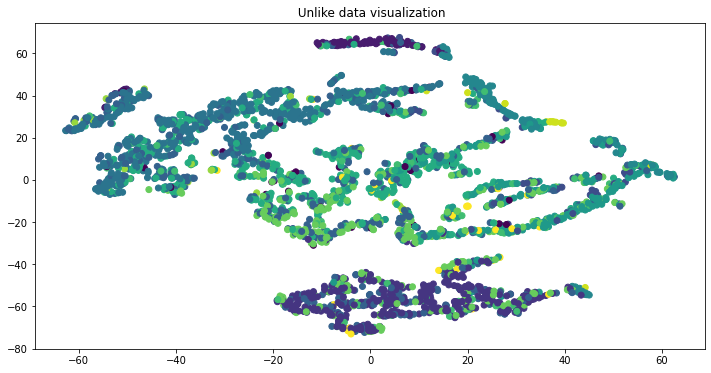

In [306]:
gmm = mixture.GaussianMixture(n_components=14,covariance_type='full')
labels = gmm.fit_predict(UnLike)
tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=30)
pos = tsne.fit_transform(UnLike)
fig = plt.figure(figsize=(12,6))
plt.scatter(pos[:, 0], pos[:, 1], c=labels)
plt.title(" Unlike data visualization")
plt.show()

# Classification 

## Complete Data

In [307]:
X = ALL_raw
y = Classification

# split the data with 70% in each set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, train_size=0.7)

### KNeighborsClassifier

In [308]:
model_knn  = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(Xtrain, ytrain)
ytest_pred_knn  = model_knn.predict(Xtest)
print('KNN:')
print(classification_report(ytest, ytest_pred_knn))

KNN:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       898
           1       0.91      0.91      0.91      1646

    accuracy                           0.88      2544
   macro avg       0.87      0.87      0.87      2544
weighted avg       0.88      0.88      0.88      2544



In [309]:
scores_knn  = cross_val_score(model_knn,  Xtest, ytest, cv=5)
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() * 2))

Accuracy KNN: 0.86 (+/- 0.03)


Text(0.5, 1.0, 'KNN')

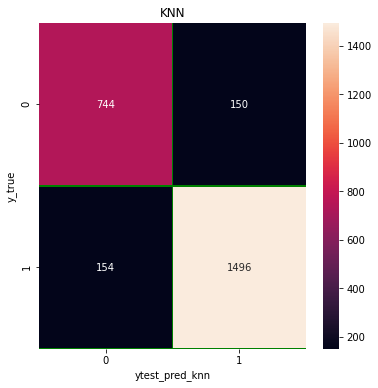

In [310]:
cm1 = confusion_matrix(ytest_pred_knn, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm1,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_knn")
plt.ylabel("y_true")
plt.title('KNN')


### Linear Discriminant Analysis

In [311]:
model_lda  = LinearDiscriminantAnalysis(n_components=None,priors=None, store_covariance=True)
model_lda.fit(Xtrain, ytrain)
ytest_pred_lda  = model_lda.predict(Xtest)
pred_prob1 = model_lda.predict_proba(Xtest)
print('LDA:')
print(classification_report(ytest, ytest_pred_lda))


LDA:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       898
           1       0.91      0.94      0.93      1646

    accuracy                           0.90      2544
   macro avg       0.90      0.89      0.89      2544
weighted avg       0.90      0.90      0.90      2544



In [312]:
scores_lda  = cross_val_score(model_lda,  Xtest, ytest, cv=5)
print("Accuracy LDA: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std() * 2))


Accuracy LDA: 0.90 (+/- 0.03)


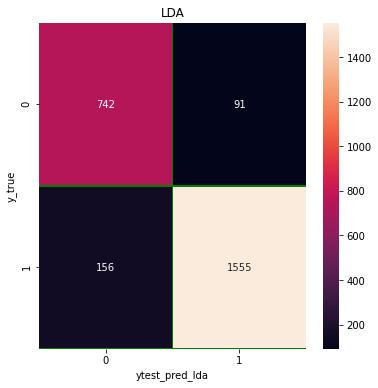

In [313]:
cm2 = confusion_matrix(ytest_pred_lda, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_lda")
plt.ylabel("y_true")
plt.title('LDA')
plt.savefig('LDAcomplete.png')



### QuadraticDiscriminantAnalysis

In [314]:
model_qda  = QuadraticDiscriminantAnalysis(priors=None,store_covariance=True)
model_qda.fit(Xtrain, ytrain)
ytest_pred_qda  = model_qda.predict(Xtest)
print('QDA:')
print(classification_report(ytest, ytest_pred_qda))


QDA:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       898
           1       0.94      0.85      0.89      1646

    accuracy                           0.87      2544
   macro avg       0.85      0.88      0.86      2544
weighted avg       0.88      0.87      0.87      2544



In [315]:
scores_qda  = cross_val_score(model_qda,  Xtest, ytest, cv=5)
print("Accuracy QDA: %0.2f (+/- %0.2f)" % (scores_qda.mean(), scores_qda.std() * 2))

Accuracy QDA: 0.87 (+/- 0.03)


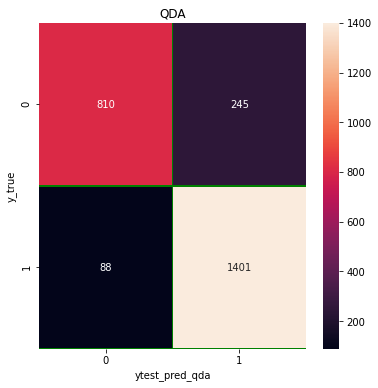

In [316]:
cm3 = confusion_matrix(ytest_pred_qda, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm3,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_qda")
plt.ylabel("y_true")
plt.title('QDA')
plt.show()

### Decision Tree Classifier

In [317]:
model_tree = DecisionTreeClassifier()
model_tree.fit(Xtrain, ytrain)
ytest_pred_tree = model_tree.predict(Xtest)
print('TREE:')
print(classification_report(ytest, ytest_pred_tree))

TREE:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       898
           1       0.94      0.93      0.93      1646

    accuracy                           0.92      2544
   macro avg       0.91      0.91      0.91      2544
weighted avg       0.92      0.92      0.92      2544



In [318]:
scores_tree = cross_val_score(model_tree, Xtest, ytest, cv=5)
print("Accuracy TREE: %0.2f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std() * 2))

Accuracy TREE: 0.89 (+/- 0.01)


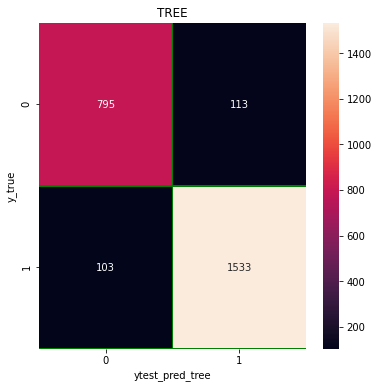

In [319]:
cm4 = confusion_matrix(ytest_pred_tree, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm4,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('TREE')
plt.show()

### GaussianNB

In [320]:
model_gnb  = GaussianNB()
model_gnb.fit(Xtrain, ytrain)
ytest_pred_gnb  = model_gnb.predict(Xtest)
print('GNB:')
print(classification_report(ytest, ytest_pred_gnb))

GNB:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       898
           1       0.94      0.81      0.87      1646

    accuracy                           0.84      2544
   macro avg       0.83      0.85      0.83      2544
weighted avg       0.86      0.84      0.84      2544



In [321]:
scores_gnb  = cross_val_score(model_gnb,  Xtest, ytest, cv=5)
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() * 2))

Accuracy GNB: 0.84 (+/- 0.03)


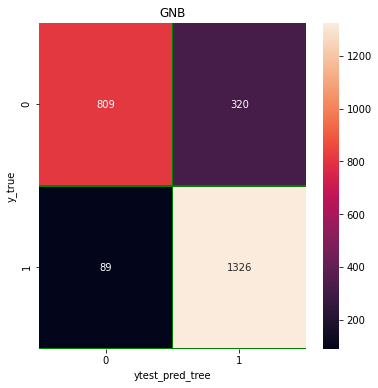

In [322]:
cm5 = confusion_matrix(ytest_pred_gnb, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm5,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('GNB')
plt.show()

## SVM

In [323]:
model_svm = SVC(kernel='poly', degree=4)
model_svm.fit(Xtrain, ytrain)
ytest_pred_svm  = model_svm.predict(Xtest)
print('SVM:')
print(classification_report(ytest, ytest_pred_svm))

SVM:
              precision    recall  f1-score   support

           0       0.79      0.32      0.46       898
           1       0.72      0.95      0.82      1646

    accuracy                           0.73      2544
   macro avg       0.75      0.64      0.64      2544
weighted avg       0.74      0.73      0.69      2544



In [324]:
scores_svm  = cross_val_score(model_svm,  Xtest, ytest, cv=5)
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))

Accuracy GNB: 0.65 (+/- 0.00)


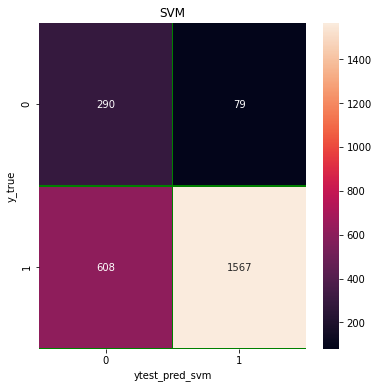

In [325]:
cm6 = confusion_matrix(ytest_pred_svm, ytest)

plt.figure(figsize=(6, 6))
sns.heatmap(cm6,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_svm")
plt.ylabel("y_true")
plt.title('SVM')
plt.show()

## Data without release data

In [326]:
ALLnoData= ALL_noDate.copy()
ALLnoData.drop('Classification', inplace=True, axis=1)

X = ALLnoData
y = Classification

# split the data with 70% in each set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, train_size=0.7)

### KNeighborsClassifier

In [327]:
model_knn  = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(Xtrain, ytrain)
ytest_pred_knn  = model_knn.predict(Xtest)
print('KNN:')
print(classification_report(ytest, ytest_pred_knn))

KNN:
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       898
           1       0.86      0.86      0.86      1646

    accuracy                           0.81      2544
   macro avg       0.80      0.80      0.80      2544
weighted avg       0.81      0.81      0.81      2544



In [328]:
scores_knn  = cross_val_score(model_knn,  Xtest, ytest, cv=5)
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() * 2))

Accuracy KNN: 0.80 (+/- 0.04)


Text(0.5, 1.0, 'KNN')

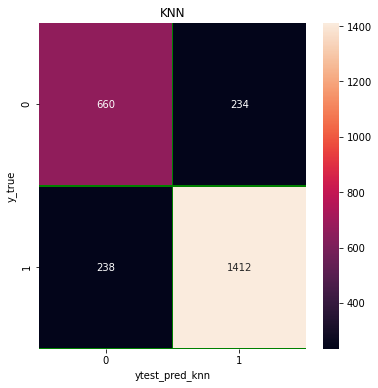

In [329]:
cm1 = confusion_matrix(ytest_pred_knn, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm1,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_knn")
plt.ylabel("y_true")
plt.title('KNN')

### LinearDiscriminantAnalysis

In [330]:
model_lda  = LinearDiscriminantAnalysis(n_components=None,priors=None, store_covariance=True)
model_lda.fit(Xtrain, ytrain)
ytest_pred_lda  = model_lda.predict(Xtest)
pred_prob2 = model_lda.predict_proba(Xtest)
print('LDA:')
print(classification_report(ytest, ytest_pred_lda))

LDA:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       898
           1       0.87      0.94      0.91      1646

    accuracy                           0.87      2544
   macro avg       0.87      0.85      0.86      2544
weighted avg       0.87      0.87      0.87      2544



In [331]:
scores_lda  = cross_val_score(model_lda,  Xtest, ytest, cv=5)
print("Accuracy LDA: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std() * 2))


Accuracy LDA: 0.87 (+/- 0.02)


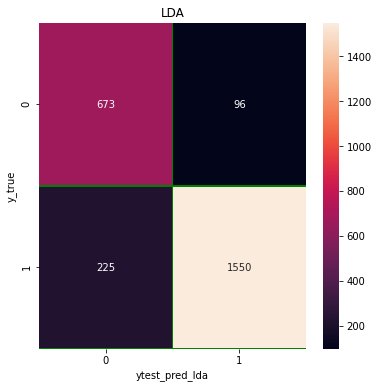

In [332]:
cm2 = confusion_matrix(ytest_pred_lda, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_lda")
plt.ylabel("y_true")
plt.title('LDA')
plt.savefig('LDAsinerelease.png')

## Quadratic Discriminant Analysis

In [333]:
model_qda  = QuadraticDiscriminantAnalysis(priors=None,store_covariance=True)
model_qda.fit(Xtrain, ytrain)
ytest_pred_qda  = model_qda.predict(Xtest)
print('QDA:')
print(classification_report(ytest, ytest_pred_qda))

QDA:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       898
           1       0.91      0.90      0.90      1646

    accuracy                           0.88      2544
   macro avg       0.86      0.87      0.86      2544
weighted avg       0.88      0.88      0.88      2544



In [334]:
scores_qda  = cross_val_score(model_qda,  Xtest, ytest, cv=5)
print("Accuracy QDA: %0.2f (+/- %0.2f)" % (scores_qda.mean(), scores_qda.std() * 2))

Accuracy QDA: 0.87 (+/- 0.03)


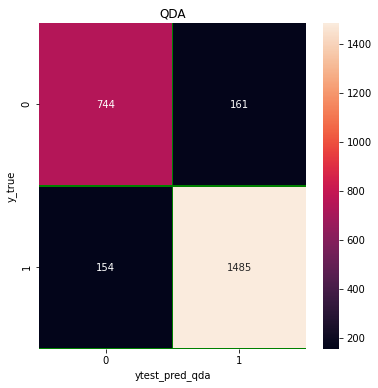

In [335]:
cm3 = confusion_matrix(ytest_pred_qda, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm3,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_qda")
plt.ylabel("y_true")
plt.title('QDA')
plt.show()

### Decision Tree Classifier

In [336]:
model_tree = DecisionTreeClassifier()
model_tree.fit(Xtrain, ytrain)
ytest_pred_tree = model_tree.predict(Xtest)
print('TREE:')
print(classification_report(ytest, ytest_pred_tree))

TREE:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       898
           1       0.91      0.91      0.91      1646

    accuracy                           0.88      2544
   macro avg       0.87      0.87      0.87      2544
weighted avg       0.88      0.88      0.88      2544



In [337]:
scores_tree = cross_val_score(model_tree, Xtest, ytest, cv=5)
print("Accuracy TREE: %0.2f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std() * 2))

Accuracy TREE: 0.87 (+/- 0.02)


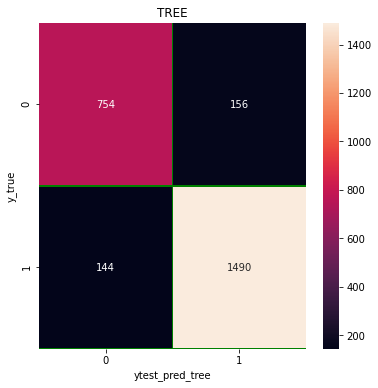

In [338]:
cm4 = confusion_matrix(ytest_pred_tree, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm4,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('TREE')
plt.show()

## Gaussian NB

In [339]:
model_gnb  = GaussianNB()
model_gnb.fit(Xtrain, ytrain)
ytest_pred_gnb  = model_gnb.predict(Xtest)
print('GNB:')
print(classification_report(ytest, ytest_pred_gnb))

GNB:
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       898
           1       0.91      0.80      0.85      1646

    accuracy                           0.82      2544
   macro avg       0.81      0.83      0.81      2544
weighted avg       0.84      0.82      0.83      2544



In [340]:
scores_gnb  = cross_val_score(model_gnb,  Xtest, ytest, cv=5)
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() * 2))

Accuracy GNB: 0.82 (+/- 0.02)


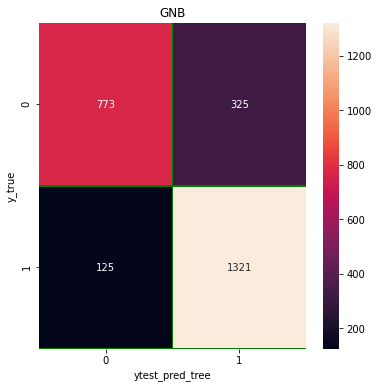

In [341]:
cm5 = confusion_matrix(ytest_pred_gnb, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm5,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('GNB')
plt.show()

## SVM

In [342]:
model_svm = SVC(kernel='poly', degree=4)
model_svm.fit(Xtrain, ytrain)
ytest_pred_svm  = model_svm.predict(Xtest)
print('SVM:')
print(classification_report(ytest, ytest_pred_svm))

SVM:
              precision    recall  f1-score   support

           0       0.79      0.54      0.64       898
           1       0.79      0.92      0.85      1646

    accuracy                           0.79      2544
   macro avg       0.79      0.73      0.75      2544
weighted avg       0.79      0.79      0.78      2544



In [343]:
scores_svm  = cross_val_score(model_svm,  Xtest, ytest, cv=5)
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))

Accuracy GNB: 0.77 (+/- 0.05)


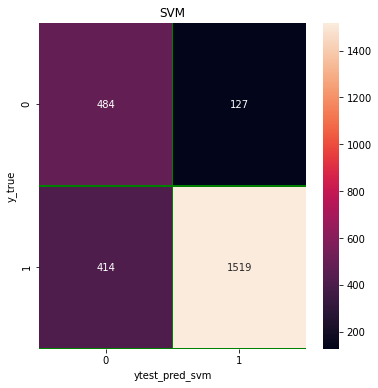

In [344]:
cm6 = confusion_matrix(ytest_pred_svm, ytest)

plt.figure(figsize=(6, 6))
sns.heatmap(cm6,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_svm")
plt.ylabel("y_true")
plt.title('SVM')
plt.show()

## Classification with reduced data

In [345]:
Xred = dfpca.copy()
Xred.drop('label', inplace=True, axis=1)
y = Classification

# split the data with 70% in each set
Xtrain, Xtest, ytrain, ytest = train_test_split(Xred, y, random_state=0, train_size=0.7)

## KNeighbors Classifier

In [346]:
model_knn  = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(Xtrain, ytrain)
ytest_pred_knn  = model_knn.predict(Xtest)
print('KNN:')
print(classification_report(ytest, ytest_pred_knn))

KNN:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       898
           1       0.92      0.93      0.93      1646

    accuracy                           0.91      2544
   macro avg       0.90      0.90      0.90      2544
weighted avg       0.91      0.91      0.91      2544



In [347]:
scores_knn  = cross_val_score(model_knn,  Xtest, ytest, cv=5)
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() * 2))

Accuracy KNN: 0.88 (+/- 0.03)


Text(0.5, 1.0, 'KNN')

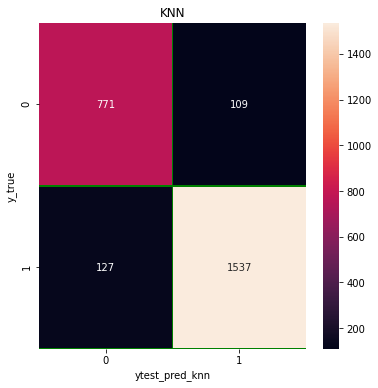

In [348]:
cm1 = confusion_matrix(ytest_pred_knn, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm1,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_knn")
plt.ylabel("y_true")
plt.title('KNN')


## LinearDiscriminantAnalysis

In [349]:
model_lda  = LinearDiscriminantAnalysis(n_components=None,priors=None, store_covariance=True)
model_lda.fit(Xtrain, ytrain)
ytest_pred_lda  = model_lda.predict(Xtest)
pred_prob3 = model_lda.predict_proba(Xtest)
print('LDA:')
print(classification_report(ytest, ytest_pred_lda))

LDA:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       898
           1       0.88      0.93      0.91      1646

    accuracy                           0.88      2544
   macro avg       0.87      0.85      0.86      2544
weighted avg       0.88      0.88      0.88      2544



In [350]:
scores_lda  = cross_val_score(model_lda,  Xtest, ytest, cv=5)
print("Accuracy LDA: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std() * 2))


Accuracy LDA: 0.88 (+/- 0.03)


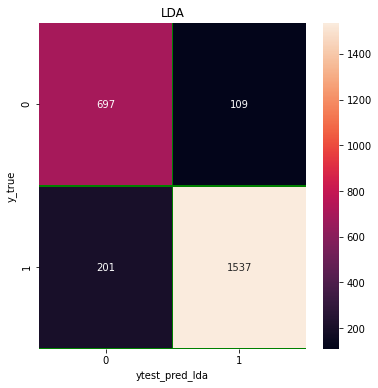

In [351]:
cm2 = confusion_matrix(ytest_pred_lda, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_lda")
plt.ylabel("y_true")
plt.title('LDA')
plt.savefig('LDAPCAcomplete.png')

## Quadratic Discriminant Analysis

In [352]:
model_qda  = QuadraticDiscriminantAnalysis(priors=None,store_covariance=True)
model_qda.fit(Xtrain, ytrain)
ytest_pred_qda  = model_qda.predict(Xtest)
print('QDA:')
print(classification_report(ytest, ytest_pred_qda))

QDA:
              precision    recall  f1-score   support

           0       0.75      0.89      0.82       898
           1       0.93      0.84      0.88      1646

    accuracy                           0.86      2544
   macro avg       0.84      0.87      0.85      2544
weighted avg       0.87      0.86      0.86      2544



In [353]:
scores_qda  = cross_val_score(model_qda,  Xtest, ytest, cv=5)
print("Accuracy QDA: %0.2f (+/- %0.2f)" % (scores_qda.mean(), scores_qda.std() * 2))


Accuracy QDA: 0.86 (+/- 0.04)


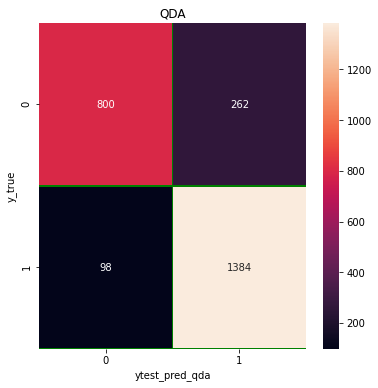

In [354]:
cm3 = confusion_matrix(ytest_pred_qda, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm3,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_qda")
plt.ylabel("y_true")
plt.title('QDA')
plt.show()


## Decision Tree Classifier

In [355]:
model_tree = DecisionTreeClassifier()
model_tree.fit(Xtrain, ytrain)
ytest_pred_tree = model_tree.predict(Xtest)
print('TREE:')
print(classification_report(ytest, ytest_pred_tree))

TREE:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       898
           1       0.88      0.90      0.89      1646

    accuracy                           0.86      2544
   macro avg       0.85      0.84      0.84      2544
weighted avg       0.86      0.86      0.86      2544



In [356]:
scores_tree = cross_val_score(model_tree, Xtest, ytest, cv=5)
print("Accuracy TREE: %0.2f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std() * 2))


Accuracy TREE: 0.85 (+/- 0.03)


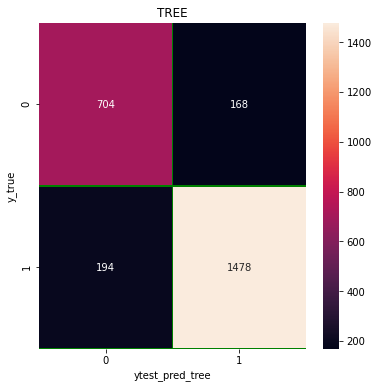

In [357]:
cm4 = confusion_matrix(ytest_pred_tree, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm4,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('TREE')
plt.show()

## Gaussian NB

In [358]:
model_gnb  = GaussianNB()
model_gnb.fit(Xtrain, ytrain)
ytest_pred_gnb  = model_gnb.predict(Xtest)
print('GNB:')
print(classification_report(ytest, ytest_pred_gnb))

GNB:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       898
           1       0.91      0.88      0.89      1646

    accuracy                           0.86      2544
   macro avg       0.85      0.86      0.85      2544
weighted avg       0.87      0.86      0.87      2544



In [359]:
scores_gnb  = cross_val_score(model_gnb,  Xtest, ytest, cv=5)
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() * 2))


Accuracy GNB: 0.87 (+/- 0.04)


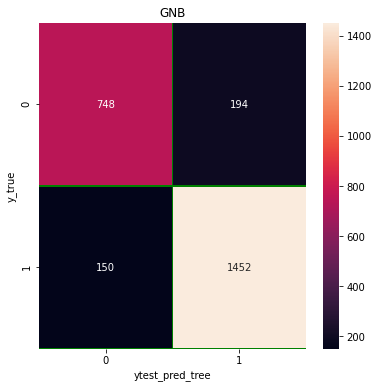

In [360]:
cm5 = confusion_matrix(ytest_pred_gnb, ytest)

plt.figure(figsize=(6, 6))
sns.heatmap(cm5,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('GNB')
plt.show()

## SVM 

In [361]:
model_svm = SVC(kernel='poly', degree=4)
model_svm.fit(Xtrain, ytrain)
ytest_pred_svm  = model_svm.predict(Xtest)
print('SVM:')
print(classification_report(ytest, ytest_pred_svm))



SVM:
              precision    recall  f1-score   support

           0       0.89      0.61      0.72       898
           1       0.82      0.96      0.88      1646

    accuracy                           0.84      2544
   macro avg       0.85      0.78      0.80      2544
weighted avg       0.84      0.84      0.83      2544



In [362]:
scores_svm  = cross_val_score(model_svm,  Xtest, ytest, cv=5)
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))


Accuracy GNB: 0.81 (+/- 0.03)


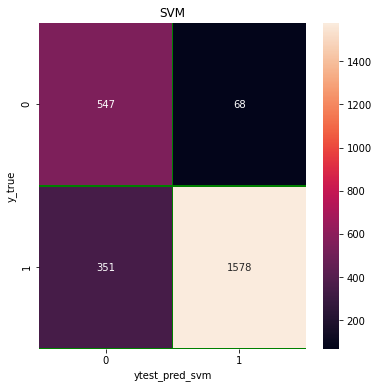

In [363]:
cm6 = confusion_matrix(ytest_pred_svm, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm6,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_svm")
plt.ylabel("y_true")
plt.title('SVM')
plt.show()


## Classification With reduced Data without realise data

In [368]:
XredND = dfpcaNoData.copy()
XredND.drop('label', inplace=True, axis=1)
y = Classification

# split the data with 70% in each set
Xtrain, Xtest, ytrain, ytest = train_test_split(XredND, y, random_state=0, train_size=0.7)

### KNeighbors Classifier

In [369]:
model_knn  = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(Xtrain, ytrain)
ytest_pred_knn  = model_knn.predict(Xtest)
pred_prob4 = model_knn.predict_proba(Xtest)
print('KNN:')
print(classification_report(ytest, ytest_pred_knn))

KNN:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       898
           1       0.90      0.92      0.91      1646

    accuracy                           0.88      2544
   macro avg       0.87      0.86      0.86      2544
weighted avg       0.88      0.88      0.88      2544



In [370]:
scores_knn  = cross_val_score(model_knn,  Xtest, ytest, cv=5)
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() * 2))

Accuracy KNN: 0.87 (+/- 0.03)


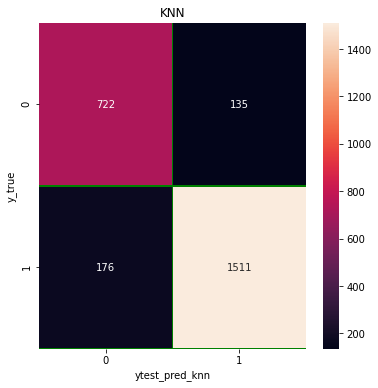

In [371]:
cm1 = confusion_matrix(ytest_pred_knn, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm1,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_knn")
plt.ylabel("y_true")
plt.title('KNN')
plt.savefig('KNNPCAsinrelease.png')


## Linear Discriminant Analysis

In [372]:
model_lda  = LinearDiscriminantAnalysis(n_components=None,priors=None, store_covariance=True)
model_lda.fit(Xtrain, ytrain)
ytest_pred_lda  = model_lda.predict(Xtest)
print('LDA:')
print(classification_report(ytest, ytest_pred_lda))

LDA:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       898
           1       0.85      0.93      0.89      1646

    accuracy                           0.85      2544
   macro avg       0.85      0.82      0.83      2544
weighted avg       0.85      0.85      0.85      2544



In [373]:
scores_lda  = cross_val_score(model_lda,  Xtest, ytest, cv=5)
print("Accuracy LDA: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std() * 2))


Accuracy LDA: 0.85 (+/- 0.04)


Text(0.5, 1.0, 'LDA')

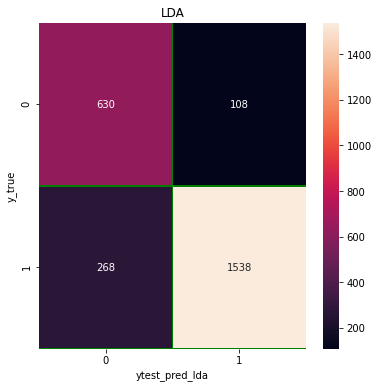

In [374]:
cm2 = confusion_matrix(ytest_pred_lda, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_lda")
plt.ylabel("y_true")
plt.title('LDA')

## Quadratic Discriminant Analysis

In [375]:
model_qda  = QuadraticDiscriminantAnalysis(priors=None,store_covariance=True)
model_qda.fit(Xtrain, ytrain)
ytest_pred_qda  = model_qda.predict(Xtest)
print('QDA:')
print(classification_report(ytest, ytest_pred_qda))

QDA:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       898
           1       0.89      0.88      0.89      1646

    accuracy                           0.85      2544
   macro avg       0.84      0.84      0.84      2544
weighted avg       0.85      0.85      0.85      2544



In [376]:
scores_qda  = cross_val_score(model_qda,  Xtest, ytest, cv=5)
print("Accuracy QDA: %0.2f (+/- %0.2f)" % (scores_qda.mean(), scores_qda.std() * 2))


Accuracy QDA: 0.85 (+/- 0.03)


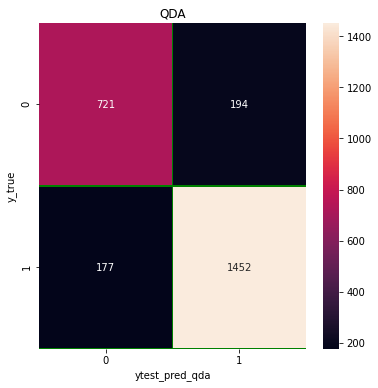

In [377]:
cm3 = confusion_matrix(ytest_pred_qda, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm3,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_qda")
plt.ylabel("y_true")
plt.title('QDA')
plt.show()


## Decision Tree Classifier

In [378]:
model_tree = DecisionTreeClassifier()
model_tree.fit(Xtrain, ytrain)
ytest_pred_tree = model_tree.predict(Xtest)
print('TREE:')
print(classification_report(ytest, ytest_pred_tree))

TREE:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       898
           1       0.88      0.89      0.89      1646

    accuracy                           0.85      2544
   macro avg       0.84      0.84      0.84      2544
weighted avg       0.85      0.85      0.85      2544



In [379]:
scores_tree = cross_val_score(model_tree, Xtest, ytest, cv=5)
print("Accuracy TREE: %0.2f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std() * 2))


Accuracy TREE: 0.82 (+/- 0.03)


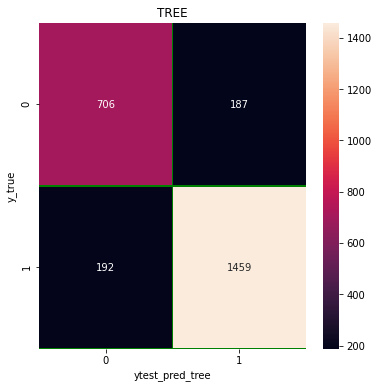

In [380]:
cm4 = confusion_matrix(ytest_pred_tree, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm4,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('TREE')
plt.show()

## GaussianNB

In [381]:
model_gnb  = GaussianNB()
model_gnb.fit(Xtrain, ytrain)
ytest_pred_gnb  = model_gnb.predict(Xtest)
print('GNB:')
print(classification_report(ytest, ytest_pred_gnb))

GNB:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       898
           1       0.88      0.86      0.87      1646

    accuracy                           0.84      2544
   macro avg       0.82      0.83      0.82      2544
weighted avg       0.84      0.84      0.84      2544



In [382]:
scores_gnb  = cross_val_score(model_gnb,  Xtest, ytest, cv=5)
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() * 2))


Accuracy GNB: 0.84 (+/- 0.03)


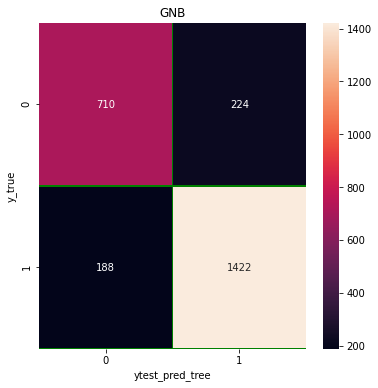

In [383]:
cm5 = confusion_matrix(ytest_pred_gnb, ytest)

plt.figure(figsize=(6, 6))
sns.heatmap(cm5,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_tree")
plt.ylabel("y_true")
plt.title('GNB')
plt.show()

## SVC

In [384]:
model_svm = SVC(kernel='poly', degree=4)
model_svm.fit(Xtrain, ytrain)
ytest_pred_svm  = model_svm.predict(Xtest)
print('SVM:')
print(classification_report(ytest, ytest_pred_svm))


SVM:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       898
           1       0.79      0.95      0.87      1646

    accuracy                           0.81      2544
   macro avg       0.83      0.75      0.77      2544
weighted avg       0.82      0.81      0.80      2544



In [385]:
scores_svm  = cross_val_score(model_svm,  Xtest, ytest, cv=5)
print("Accuracy GNB: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))


Accuracy GNB: 0.78 (+/- 0.03)


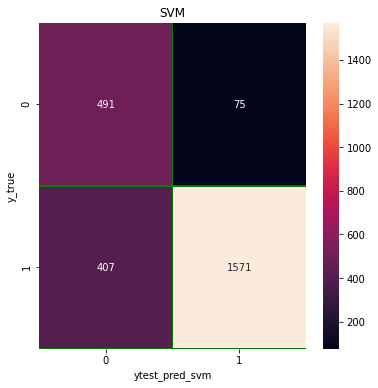

In [386]:
cm6 = confusion_matrix(ytest_pred_svm, ytest)
plt.figure(figsize=(6, 6))
sns.heatmap(cm6,annot = True,linewidths=0.5,linecolor="green",fmt = ".0f")
plt.xlabel("ytest_pred_svm")
plt.ylabel("y_true")
plt.title('SVM')
plt.show()

# ROC plot

In [387]:
fpr1, tpr1, thresh1 = roc_curve(ytest, pred_prob1[:,1])
fpr2, tpr2, thresh2 = roc_curve(ytest, pred_prob2[:,1])
fpr3, tpr3, thresh3 = roc_curve(ytest, pred_prob3[:,1])
fpr4, tpr4, thresh4 = roc_curve(ytest, pred_prob4[:,1])


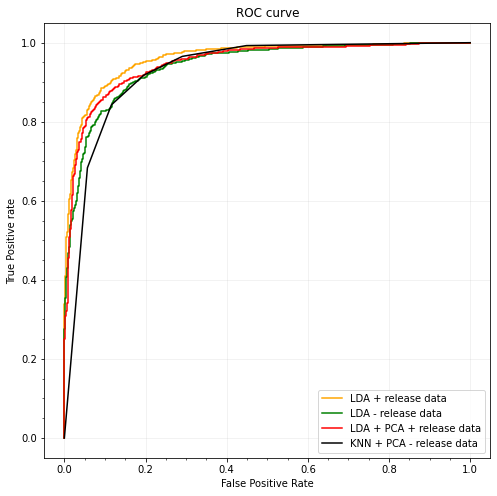

In [388]:
plt.figure(figsize=[8,8])
plt.plot(fpr1, tpr1,color='orange', label='LDA + release data')
plt.plot(fpr2, tpr2,color='green', label='LDA - release data')
plt.plot(fpr3, tpr3,color='red', label='LDA + PCA + release data')
plt.plot(fpr4, tpr4,color='black', label='KNN + PCA - release data')
plt.grid(True, alpha=0.2)
plt.minorticks_on()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.savefig('ROCcurve.png')
plt.show();